## Import Necessary Packages

In [4]:
import glob
import warnings
import numpy as np
import xarray as xr
# import proplot as pplt
# pplt.rc.reso='hi'
# pplt.rc.fontsize=10
warnings.filterwarnings('ignore')

In [ ]:
filepath = '/ocean/projects/atm200007p/sferrett/Archived/F-monsoon-pr-old/'
latmin=8; latmax=22; lonmin=62; lonmax=78
labels = ['June','July','August']
colors = ['red6','green6','blue6']
months=[6,7,8]

## Fig. 1

In [4]:
era5files  = sorted(glob.glob(f'{filepath}era5/ERA5_JJAS_2000_2021_*_monthly.nc'))
imergfiles = sorted(glob.glob(f'{filepath}processed/IMERG_JJAS_*_pr_daily.nc')) 
data = xr.merge(
    [xr.open_mfdataset(era5files).rename({'latitude':'lat','longitude':'lon'}),
     xr.open_mfdataset(imergfiles)])
data = data.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
data = data.where(data['time.month']!=9,drop=True)
data = data.groupby('time.month').mean(dim='time')

In [5]:
x,y = np.meshgrid(data.lon[::10],data.lat[::10])
u,v = data.u[:,::10,::10],data.v[:,::10,::10]

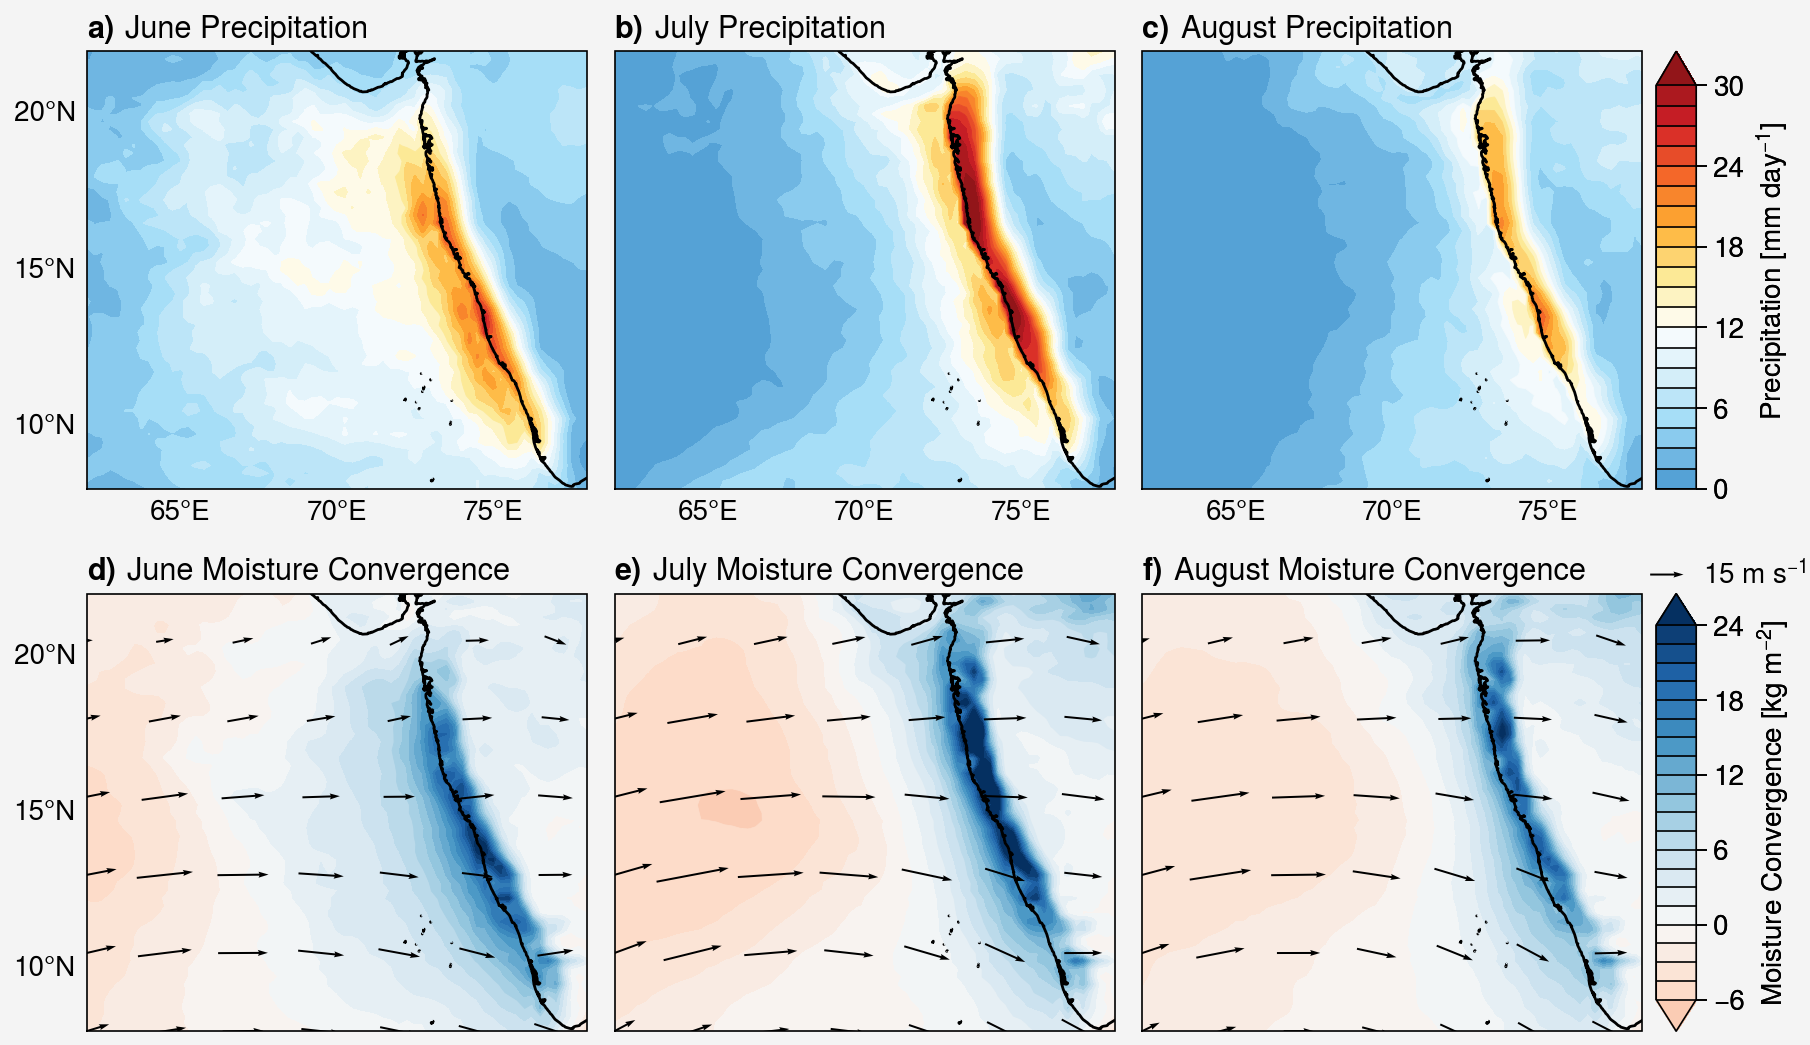

In [16]:
vimdstyle = dict(cmap='RdBu',levels=21,vmin=-6,vmax=24,extend='both')
windstyle = dict(color='k',scale=150,pivot='middle',width=0.004)
prstyle = dict(cmap='ColdHot',levels=20,vmin=0,vmax=30,extend='max',cmap_kw={'left':0.2})

fig,axs = pplt.subplots(nrows=2,ncols=3,proj='cyl',refwidth=2.5,share=True,span=True)
axs.format(abcloc='l',abc='a)',titleloc='l',
           grid=False,lonlim=(lonmin,lonmax),latlim=(latmin,latmax),coast=True,coastlinewidth=1)
for i,month in enumerate(months):
    a = axs[i+3].contourf(data.vimd[i]*-1,**vimdstyle)
    b = axs[i+3].quiver(x,y,u[i],v[i],**windstyle)
    c = axs[i].contourf(data.pr[i],**prstyle)
    axs[i].format(title=labels[i]+' Precipitation',lonlines=5,lonlabels='b')
    axs[i+3].format(title=labels[i]+' Moisture Convergence')
    axs[3*i-3].format(latlines=5,latlabels='l')
axs[5].colorbar(a,loc='r',grid=True,ticks=6,label='Moisture Convergence [kg m$^{-2}$]')
axs[2].quiverkey(b,0.93,0.45,10,label=r'15 m s$^{-1}$',labelpos='E',coordinates='figure')
axs[2].colorbar(c,loc='r',grid=True,ticks=6,label='Precipitation [mm day$^{-1}$]')
fig.save('fig_1.png',dpi=300)

## Fig. 2

In [6]:
# blfiles = sorted(glob.glob(f'{filepath}/processed/ERA5_JJAS_*_bl_terms_hourly.nc'))
# prfiles = sorted(glob.glob(f'{filepath}/processed/IMERG_JJAS_*_pr_daily.nc'))              
# data = xr.merge([xr.open_mfdataset(prfiles),xr.open_mfdataset(blfiles)])
# data = data.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
# data = data.where(data['time.month']!=9,drop=True)
# data['pr'] = data.pr.where(data.pr>=0,0)

data = data.sel(time=slice('2000','2014'))

In [9]:
blthresh = -0.035
prstyle = dict(vmin=0,vmax=30,levels=20,cmap='ColdHot',extend='max',cmap_kw={'left':0.2})
blstyle = dict(color='indigo',levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],linewidth=0.5)

fig,axs = pplt.subplots(nrows=1,ncols=3,proj='cyl',refwidth=2.5,share=True,span=True)
# axs.format(collabels=labels,grid=False,lonlim=(lonmin,lonmax),latlim=(latmin,latmax),
#            coast=True,coastlinewidth=1)
axs.format(abc='A)',abcloc='ul',grid=False,lonlim=(lonmin,lonmax),latlim=(latmin,latmax),
           coast=True,coastlinewidth=1)
    
for i,month in enumerate(months):
    group = data.groupby('time.month')[month]
    meanpr  = group.pr.mean(dim='time')
    countbl = group.bl.where(group.bl>blthresh).count(dim='time')/group.bl.count(dim='time')
    a = axs[i].contourf(meanpr,**prstyle)
    b = axs[i].contour(countbl,**blstyle)  
    # axs[i].format(lonlines=5,lonlabels='b')
    axs[i].format(title=labels[i],lonlines=5,lonlabels='b')
    axs[i].clabel(b,inline=True,fontsize=9)
axs[0].format(latlines=5,latlabels='l')
fig.colorbar(a,loc='r',grid=True,ticks=3,label='Total Precipitation [mm day $^{-1}$]')

ValueError: Invalid projection name 'cyl'. If you are trying to generate a GeoAxes with a cartopy.crs.Projection or mpl_toolkits.basemap.Basemap then cartopy or basemap must be installed. Otherwise the known axes subclasses are:
 cartesian        CartesianAxes
 cart             CartesianAxes
 rect             CartesianAxes
 rectilinar       CartesianAxes
 polar            PolarAxes
 cartopy          GeoAxes
 geo              GeoAxes
 geographic       GeoAxes
 basemap          GeoAxes
 three            ThreeAxes
 3d               ThreeAxes

Figure(refwidth=2.5)

## Figs. 3 and 4

In [99]:
blfiles  = sorted(glob.glob(f'{filepath}processed/ERA5_JJAS_*_bl_terms_hourly.nc'))
prfiles  = sorted(glob.glob(f'{filepath}processed/IMERG_JJAS_*_pr_daily.nc'))  
lsmfiles = sorted(glob.glob(f'{filepath}era5/era5_land_sea_mask_*_hourly_45E-90E_0N-30N.nc'))

In [100]:
lsm = xr.open_mfdataset(lsmfiles).rename({'latitude':'lat','longitude':'lon'})
lsm.coords['time'] = lsm.time.dt.floor('1D')
lsm = lsm.groupby('time').mean()

data = xr.merge([lsm,xr.open_mfdataset(blfiles),xr.open_mfdataset(prfiles)])
data = data.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
data = data.where(data['time.month']!=9,drop=True)
data = data.where(data.pr>0)

In [101]:
def getbins(binmin,binmax,binwidth):
    bins = np.arange(binmin,binmax+binwidth,binwidth)
    return bins

def flatten(x,y):
    x,y  = np.array(x).reshape(-1),np.array(y).reshape(-1)
    x,y  = x[~np.isnan(x)],y[~np.isnan(y)]
    return x,y

def getbinnedmean(x,y,bins):
    x,y  = flatten(x,y)
    xbinned = (bins[1:]+bins[:-1])/2
    ybinned = [np.mean(y[np.digitize(x,bins)==i]) for i in range(1,len(bins))]
    return xbinned,ybinned

In [102]:
scale  = (3.0*340.0)/9.81
blbins = getbins(binmin=-60.0,binmax=30.0,binwidth=1)/scale
capebins = getbins(binmin=-63.0,binmax=28.0,binwidth=1)
subsatbins = getbins(binmin=-30.0,binmax=61.0,binwidth=1)

### Fig. 3

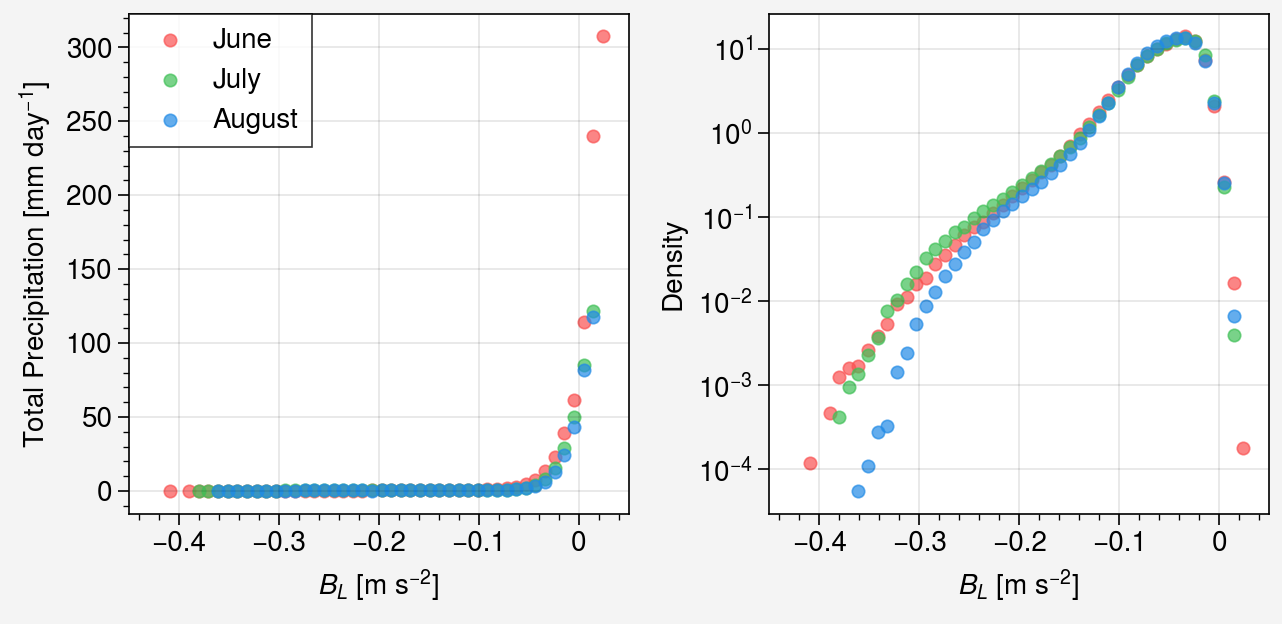

In [104]:
style = dict(marker='o',s=20,alpha=0.7)
cases = [(6,'June','red6'),(7,'July','green6'),(8,'August','blue6')]

fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=2.5,share=False,span=False)
axs.format(xlabel='$\mathit{B_L}$ [m s$^{-2}$]',xticks=0.1,xlim=(-0.45,0.05))
for i,(month,label,color) in enumerate(cases):
    group = data.groupby('time.month')[month]
    blpdf = np.histogram(group.bl,bins=blbins,density=True)[0]
    blbinned,prbinned = getbinnedmean(group.bl,group.pr,blbins)
    axs[0].scatter(blbinned,prbinned,label=label,color=color,**style)
    axs[1].scatter(blbinned,blpdf,color=color,**style)
axs[0].format(ylabel='Total Precipitation [mm day$^{-1}$]')
axs[1].format(ylabel='Density',yscale='log',yformatter='log',yminorticks=[])
axs[0].legend(loc='ul',ncols=1)

### Fig. 4

In [ ]:
style  = dict(s=20,alpha=0.7)
cases  = [(6,'June','red6'),(7,'July','green6'),(8,'August','blue6')]
covers = [(data.where(data.lsm>0.5),'Land','d'),(data.where(data.lsm<=0.5),'Ocean','o')]

fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=3,share=False,span=False)
axs.format(xlabel='$\mathit{B_L}$ [m s$^{-2}$]',xticks=0.1,xlim=(-0.45,0.05))
for i,(month,label,color) in enumerate(cases):
    for j,(mask,cover,marker) in enumerate(covers):
        group = mask.groupby('time.month')[month]
        blpdf = np.histogram(group.bl,bins=blbins,density=True)[0]
        blbinned,prbinned = getbinnedmean(group.bl,group.pr,blbins)
        axs[0].scatter(blbinned,prbinned,label=f'{label} ({cover})',color=color,marker=marker,**style)
        axs[1].scatter(blbinned,blpdf,color=color,marker=marker,**style)
axs[0].format(ylabel='Total Precipitation [mm day$^{-1}$]')
axs[1].format(ylabel='Density',yscale='log',yformatter='log',yminorticks=[])
axs[0].legend(loc='ul',ncols=1)